In [2]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers

# tf _version_ 2.14.0
np.set_printoptions(precision = 3, suppress = True)


In [3]:
# predict fuel efficiency

# loading
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [6]:
# one-hot code
dataset = raw_dataset.copy()

#clean data
dataset = dataset.dropna()

dataset['Origin'] = dataset['Origin'].map({1:'USA', 2: 'Europe',3 : 'Japan'})

dataset = pd.get_dummies(dataset, columns = ['Origin'], prefix ='', prefix_sep = '')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [7]:
# split data into train and test dataset
train_dataset = dataset.sample(frac = 0.8, random_state = 0)
test_dataset = dataset.drop(train_dataset.index)

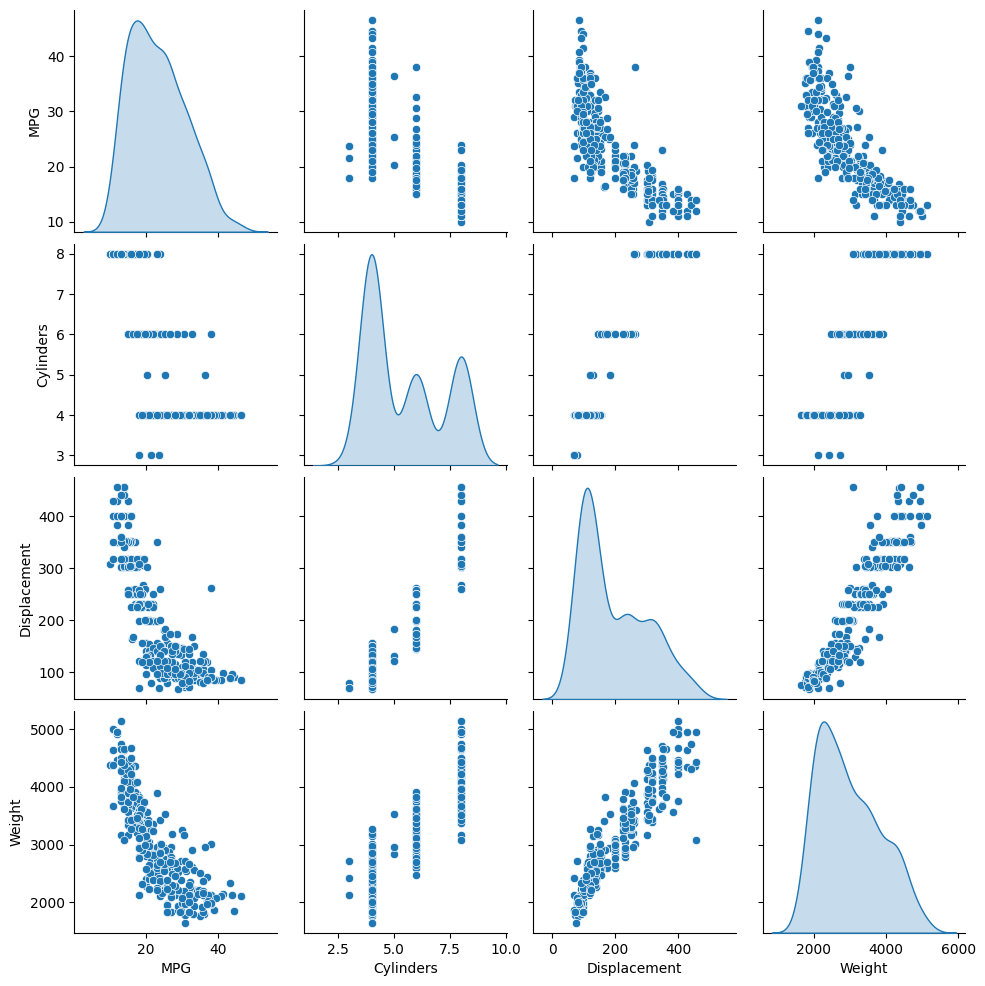

In [8]:
# inspect data
sns.pairplot(train_dataset[['MPG','Cylinders','Displacement','Weight']], diag_kind = 'kde')

In [9]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [10]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [11]:
train_dataset.describe().transpose()[['mean','std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [12]:
# normalization

normalizer = tf.keras.layers.Normalization(axis = -1)
normalizer.adapt(np.array(train_features))
normalizer.mean

<tf.Tensor: shape=(1, 9), dtype=float32, numpy=
array([[   5.478,  195.318,  104.869, 2990.252,   15.559,   75.898,
           0.178,    0.197,    0.624]], dtype=float32)>

In [13]:
first = np.array(train_features[:1])
normalizer(first).numpy()

array([[-0.871, -1.011, -0.785, -1.027, -0.38 , -0.517, -0.466, -0.496,
         0.776]], dtype=float32)

In [19]:
# linear regression with one variable
# 1 - normalize horsepower
# 2 - apply y = mx+b to produce 1 output by using dense layer

horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape = [1,], axis = None)
horsepower_normalizer.adapt(horsepower)


horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units = 1)
])

horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense_2 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5 (24.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [20]:
horsepower_model.predict(horsepower[:10])

1/1 [==============================] - 0s 94ms/step


array([[-0.124],
       [-0.07 ],
       [ 0.23 ],
       [-0.174],
       [-0.158],
       [-0.062],
       [-0.187],
       [-0.158],
       [-0.041],
       [-0.07 ]], dtype=float32)

In [21]:
horsepower_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1),
    loss = 'mean_absolute_error'
)

In [24]:
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs = 100,
    verbose = 0,
    validation_split = 0.2
)

In [35]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

hist

,loss,val_loss,epoch
0,22.880199,22.934145,0
1,22.075029,22.134747,1
2,21.261969,21.334620,2
3,20.466297,20.534323,3
4,19.662519,19.734417,4
...,...,...,...
95,3.802969,4.180656,95
96,3.805219,4.211470,96
97,3.807048,4.206726,97
98,3.805759,4.165143,98


In [42]:
def plot_test(history):
  plt.plot(history.history['loss'], label = 'loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.ylim([0,10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

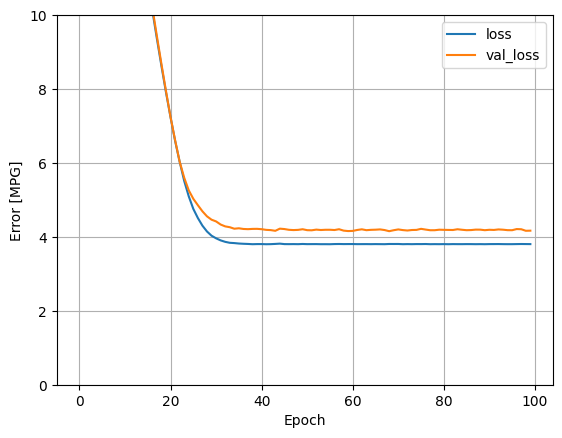

In [43]:
plot_test(history)

In [44]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(test_features['Horsepower'],
                                                             test_labels,
                                                             verbose = 0)

In [53]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)


8/8 [==============================] - 0s 3ms/step


In [56]:
def plot_horsepower(x,y):
  plt.scatter(train_features['Horsepower'], train_labels, label = 'Data')
  plt.plot(x,y, color = 'r',label = 'Prediction')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

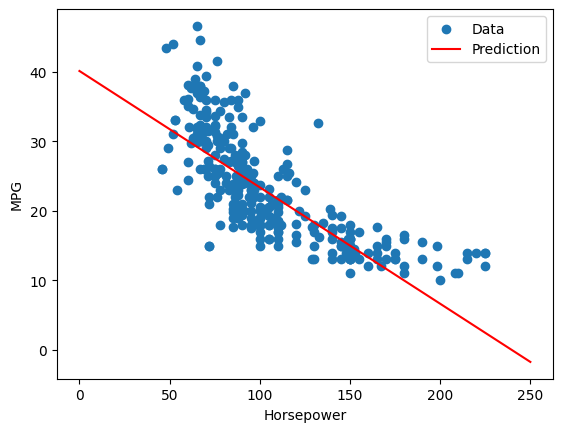

In [57]:
plot_horsepower(x,y)

In [58]:
# linear regression with multiple inputs

linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units = 1)
])

In [59]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 94ms/step


array([[ 1.041],
       [ 0.062],
       [ 0.378],
       [ 0.442],
       [-1.307],
       [ 0.472],
       [-1.128],
       [-1.529],
       [ 0.89 ],
       [-0.872]], dtype=float32)

In [61]:
linear_model.layers[1].kernel
# kernel weights is m in y = mx+b

<tf.Variable 'dense_3/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.656],
       [-0.191],
       [ 0.033],
       [-0.694],
       [ 0.085],
       [-0.26 ],
       [-0.038],
       [-0.303],
       [ 0.597]], dtype=float32)>

In [64]:
linear_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1),
    loss = 'mean_absolute_error'
)

In [66]:
history_ = linear_model.fit(
    train_features,
    train_labels,
    epochs = 100,
    verbose = 0,
    validation_split = 0.2
)

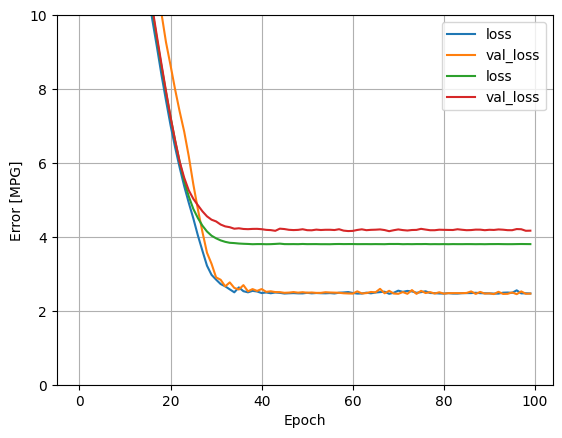

In [71]:
plot_test(history_)
plot_test(history)

In [72]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [75]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation = 'relu'),
      layers.Dense(64, activation = 'relu'),
      layers.Dense(1)
  ])

  model.compile(loss = 'mean_absolute_error',
                optimizer = tf.keras.optimizers.Adam(0.001))
  return model

In [76]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [78]:
history_dnn = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split = 0.2,
    verbose = 0,epochs = 100
)

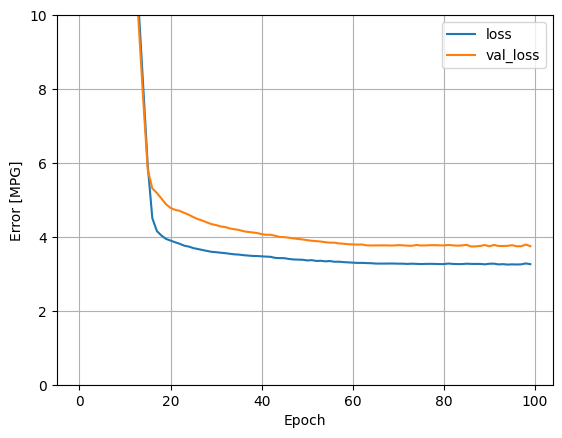

In [79]:
plot_test(history_dnn)

8/8 [==============================] - 0s 4ms/step


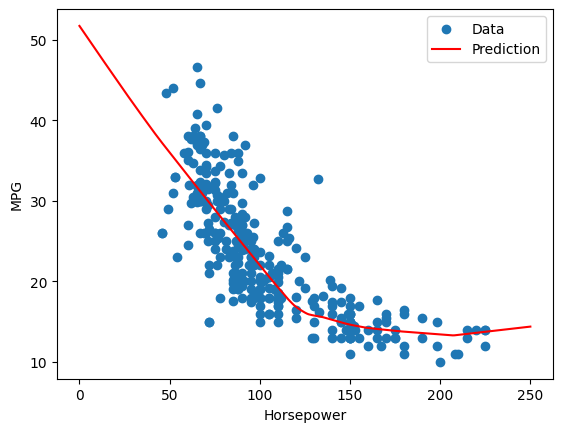

In [80]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

plot_horsepower(x,y)

In [90]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

In [91]:
# Regression using a DNN and multiple inputs



dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 9)                 19        
 on)                                                             
                                                                 
 dense_10 (Dense)            (None, 64)                640       
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4884 (19.08 KB)
Trainable params: 4865 (19.00 KB)
Non-trainable params: 19 (80.00 Byte)
_________________________________________________________________


In [96]:

history_dnn = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)


In [93]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.651381
linear_model,2.498284
dnn_horsepower_model,2.917911
dnn_m_model,1.794916
dnn_model,1.625690


3/3 [==============================] - 0s 5ms/step


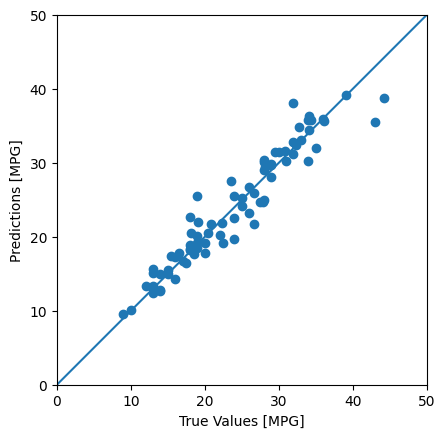

In [101]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Text(0.5, 0, 'Prediction Error [MPG]')

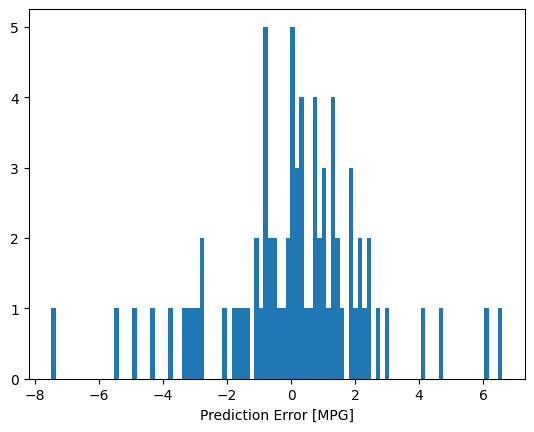

In [106]:
error = test_predictions - test_labels
plt.hist(error, bins = 100)
plt.xlabel('Prediction Error [MPG]')


In [110]:
dnn_model.save('dnn_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [111]:
reloaded = tf.keras.models.load_model('dnn_model.h5')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

ValueError: ignored